# Creating a PINN to simulation 2D incompressible Navier-Stokes

We will taken training data from OpenFOAM tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Ofpp as ofpp
import matplotlib.animation as animation
import os
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math

/Users/harry/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_animation = False

In [3]:
#Read in key parameters from control dict eventually
openfoam_case_path = "../../data/cavity/"

start_time = 0
end_time = 5
dt = 0.005
ofoam_write_interval = 1
ofoam_output_inc = dt * ofoam_write_interval
ofoam_num_outputs = ( end_time / ofoam_output_inc ) + 1
numt = len(np.arange(start_time,end_time + ofoam_output_inc,ofoam_output_inc))

x_start = 0
x_end = 20
numx = 20

y_start = 0
y_end = 20
numy = 20

viscosity = 0.01

shape = (numt,numy,numx)
print(f"OpenFOAM data shape: {shape}")

print(f"Start: {start_time} end: {end_time}")
print(f"dt: {dt} num timesteps: {numt}")
print(f"Write interval: {ofoam_write_interval} ofoam_num_outputs: {ofoam_num_outputs}")

grid2d_x, grid2d_y = np.meshgrid(
    np.linspace(x_start,x_end,numx),
    np.linspace(y_start,y_end,numy))

u_full = np.zeros(shape)
v_full = np.zeros(shape)
p_full = np.zeros(shape)

openfoam_outputs = os.listdir(openfoam_case_path)
openfoam_outputs.remove("constant")
openfoam_outputs.remove("system")
openfoam_outputs.remove("0_orig")
openfoam_outputs.sort()
openfoam_outputs = openfoam_outputs[::ofoam_write_interval]

idx = 0
for time in openfoam_outputs:
    openfoam_timestep = openfoam_case_path + time
    if time == "0":
        u_full[idx,:,:] = 0
        u_full[idx,-1,:] = 1 #Initial condition, last row all columns
        
        v_full[idx,:,:] = 0
        
        p_full[idx,:,:] = 0
    else:
        U = ofpp.parse_internal_field(f"{openfoam_timestep}/U")
        u_full[idx,:,:] = U[:,0].reshape((numy,numx))
        v_full[idx,:,:] = U[:,1].reshape((numy,numx))
        
        p_full[idx,:,:] = ofpp.parse_internal_field(f"{openfoam_timestep}/p").reshape((numy,numx))
    
    idx += 1


OpenFOAM data shape: (1001, 20, 20)
Start: 0 end: 5
dt: 0.005 num timesteps: 1001
Write interval: 1 ofoam_num_outputs: 1001.0


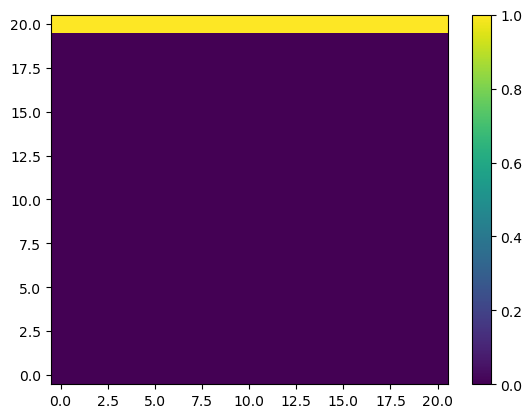

In [4]:
fig, ax = plt.subplots()
fig.colorbar(ax.pcolormesh(grid2d_x, grid2d_y, u_full[0,:,:], shading='gouraud'), orientation='vertical')
ax.pcolormesh(grid2d_x, grid2d_y,u_full[0,:,:])
plt.show()

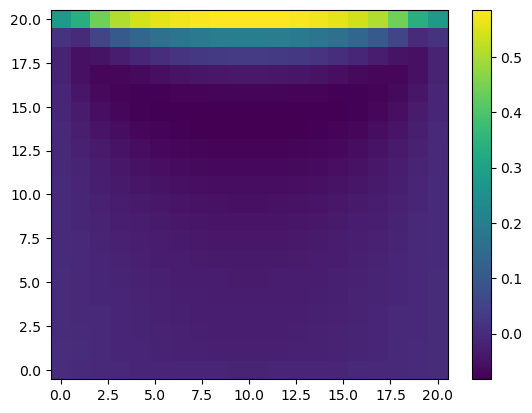

In [5]:
fig, ax = plt.subplots()
fig.colorbar(ax.pcolormesh(grid2d_x, grid2d_y, u_full[1,:,:], shading='gouraud'), orientation='vertical')
ax.pcolormesh(grid2d_x, grid2d_y,u_full[1,:,:])
plt.show()

In [6]:
#Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [7]:
y, t, x = np.meshgrid(
    np.linspace(y_start,y_end,numy),
    np.linspace(start_time,end_time,numt), #z direction
    np.linspace(x_start,x_end,numx)) #cols

print(x.shape)

#Return an array in form t, x, y
features = np.concatenate((t.flatten().reshape(-1,1),y.flatten().reshape(-1,1),x.flatten().reshape(-1,1)), axis=1)
print(features.shape)

(1001, 20, 20)
(400400, 3)


In [8]:
print(x[0,0,:])

print(y[0,:,0])

print(t[:,0,0])

[ 0.          1.05263158  2.10526316  3.15789474  4.21052632  5.26315789
  6.31578947  7.36842105  8.42105263  9.47368421 10.52631579 11.57894737
 12.63157895 13.68421053 14.73684211 15.78947368 16.84210526 17.89473684
 18.94736842 20.        ]
[ 0.          1.05263158  2.10526316  3.15789474  4.21052632  5.26315789
  6.31578947  7.36842105  8.42105263  9.47368421 10.52631579 11.57894737
 12.63157895 13.68421053 14.73684211 15.78947368 16.84210526 17.89473684
 18.94736842 20.        ]
[0.    0.005 0.01  ... 4.99  4.995 5.   ]


In [9]:
#Order is T,Y,X
print(features[1,:])
print(features[4000,:])
print(features[20,:])

[0.         0.         1.05263158]
[0.05 0.   0.  ]
[0.         1.05263158 0.        ]


In [10]:
std_scaler = StandardScaler()
scaler_features = std_scaler.fit(features)

OK, so we have our features x,y and t locations.

In the order T,Y,X

Now we need to extract our labels ensuring that the arrays are reshaped the same way as the features arrays.

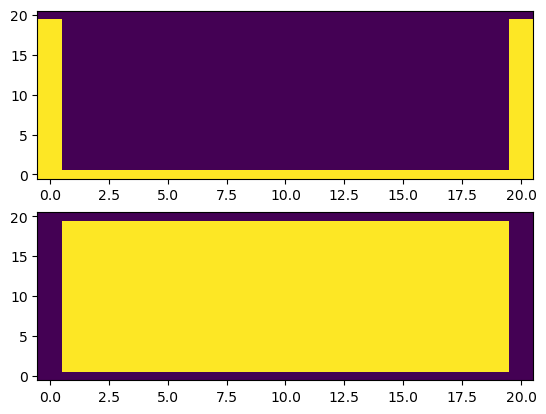

In [11]:
#Lets check our numpy slicing syntax is correct by labelling the boundary locations on a plot
boundary_qc = np.zeros(u_full[1,:,:].shape)
boundary_qc[0,:] = 1 #bottom wall
boundary_qc[1:-1,0] = 1 #left wall
boundary_qc[1:-1,-1] = 1 #right wall

#Now lets get the interior datapoints
interior_qc = np.zeros(u_full[0,:,:].shape)
interior_qc[1:-1,1:-1] = 1 #all rows and columns but first and last

fig, ax = plt.subplots(2)
#Boundary should be 1, interior and initial condition should be zero
ax[0].pcolormesh(grid2d_x, grid2d_y, boundary_qc)
#Interior should be 1, boundaries should be zero
ax[1].pcolormesh(grid2d_x, grid2d_y, interior_qc)
plt.show()

In [12]:
u_basewall  = u_full[:,0,:]
u_leftwall  = u_full[:,1:-1,0]
u_rightwall = u_full[:,1:-1,-1]

u_basewall_labels = u_basewall.flatten().reshape(-1,1)
u_leftwall_labels = u_leftwall.flatten().reshape(-1,1)
u_rightwall_labels = u_rightwall.flatten().reshape(-1,1)

v_basewall  = v_full[:,0,:]
v_leftwall  = v_full[:,1:-1,0]
v_rightwall = v_full[:,1:-1,-1]

v_basewall_labels = v_basewall.flatten().reshape(-1,1)
v_leftwall_labels = v_leftwall.flatten().reshape(-1,1)
v_rightwall_labels = v_rightwall.flatten().reshape(-1,1)

p_basewall  = p_full[:,0,:]
p_leftwall  = p_full[:,1:-1,0]
p_rightwall = p_full[:,1:-1,-1]

p_basewall_labels = p_basewall.flatten().reshape(-1,1)
p_leftwall_labels = p_leftwall.flatten().reshape(-1,1)
p_rightwall_labels = p_rightwall.flatten().reshape(-1,1)

print(u_basewall.shape)
print(u_leftwall.shape)
print(u_rightwall.shape)

print(u_basewall_labels.shape)
print(u_leftwall_labels.shape)
print(u_rightwall_labels.shape)

(1001, 20)
(1001, 18)
(1001, 18)
(20020, 1)
(18018, 1)
(18018, 1)


In [13]:
basewall_features_x = x[:,0,:]
basewall_features_y = y[:,0,:]
basewall_features_t = t[:,0,:]

leftwall_features_x = x[:,1:-1,0]
leftwall_features_y = y[:,1:-1,0]
leftwall_features_t = t[:,1:-1,0]

rightwall_features_x = x[:,1:-1,-1]
rightwall_features_y = y[:,1:-1,-1]
rightwall_features_t = t[:,1:-1,-1]

features_basewall = np.concatenate(
    (
        basewall_features_t.flatten().reshape(-1,1),
        basewall_features_y.flatten().reshape(-1,1),
        basewall_features_x.flatten().reshape(-1,1)
    ), 
    axis=1)

features_leftwall = np.concatenate(
    (
        leftwall_features_t.flatten().reshape(-1,1),
        leftwall_features_y.flatten().reshape(-1,1),
        leftwall_features_x.flatten().reshape(-1,1)
    ), 
    axis=1)

features_rightwall = np.concatenate(
    (
        rightwall_features_t.flatten().reshape(-1,1),
        rightwall_features_y.flatten().reshape(-1,1),
        rightwall_features_x.flatten().reshape(-1,1)
    ), 
    axis=1)

print(features_basewall.shape)
print(features_rightwall.shape)
print(features_leftwall.shape)

print("Starting index for each boundary (t,y,x)")
print(features_basewall[0,...])
print(features_rightwall[0,...])
print(features_leftwall[0,...])

print("Final index for each boundary (t,y,x)")
print(features_basewall[-1,...])
print(features_rightwall[-1,...])
print(features_leftwall[-1,...])


(20020, 3)
(18018, 3)
(18018, 3)
Starting index for each boundary (t,y,x)
[0. 0. 0.]
[ 0.          1.05263158 20.        ]
[0.         1.05263158 0.        ]
Final index for each boundary (t,y,x)
[ 5.  0. 20.]
[ 5.         18.94736842 20.        ]
[ 5.         18.94736842  0.        ]


In [14]:
interior_features_x = x[:,1:-1,1:-1]
interior_features_y = y[:,1:-1,1:-1]
interior_features_t = t[:,1:-1,1:-1]

In [15]:
features_interior = np.concatenate(
    (
        interior_features_t.flatten().reshape(-1,1),
        interior_features_y.flatten().reshape(-1,1),
        interior_features_x.flatten().reshape(-1,1)
    ), 
    axis=1)

print(features_interior.shape)

print("Starting index for interior points (t,y,x)")
print(features_interior[0,...])

print("Final index for interior (t,y,x)")
print(features_interior[-1,...])


(324324, 3)
Starting index for interior points (t,y,x)
[0.         1.05263158 1.05263158]
Final index for interior (t,y,x)
[ 5.         18.94736842 18.94736842]


In [16]:
#Now need interior labels
u_interior  = u_full[:,1:-1,1:-1]
u_interior_labels = u_interior.flatten().reshape(-1,1)

v_interior  = v_full[:,1:-1,1:-1]
v_interior_labels = v_interior.flatten().reshape(-1,1)

p_interior  = p_full[:,1:-1,1:-1]
p_interior_labels = p_interior.flatten().reshape(-1,1)

Great that also looks good

So we now have data for the loss condition:

- boundary condition points (should all equal 0)
- interior points (should honour the PDE)

The next steps are to scale our features

In [17]:
#Scale features
scaled_features_basewall = scaler_features.transform(features_basewall)
scaled_features_interior = scaler_features.transform(features_interior)
scaled_features_leftwall = scaler_features.transform(features_leftwall)
scaled_features_rightwall = scaler_features.transform(features_rightwall)

#REMOVE THIS WHEN HAPPY WITH CODE!
scaled_features_basewall = features_basewall
scaled_features_interior = features_interior
scaled_features_leftwall = features_leftwall
scaled_features_rightwall = features_rightwall

In [18]:
#Now split each dataset into training and testing

#Train test splitting
test_size = 0.7

#Interior
(
    x_interior_train,
    x_interior_test,
    y_interior_train,
    y_interior_test,
    t_interior_train,
    t_interior_test,
    u_interior_train,
    u_interior_test,
    v_interior_train,
    v_interior_test,
    p_interior_train,
    p_interior_test,
) = train_test_split(
    scaled_features_interior[:,2], 
    scaled_features_interior[:,1], 
    scaled_features_interior[:,0],
    u_interior_labels,
    v_interior_labels,
    p_interior_labels,
    test_size=test_size)

#Basewall
(
    x_basewall_train,
    x_basewall_test,
    y_basewall_train,
    y_basewall_test,
    t_basewall_train,
    t_basewall_test,
    u_basewall_train,
    u_basewall_test,
    v_basewall_train,
    v_basewall_test,
    p_basewall_train,
    p_basewall_test,
) = train_test_split(
    scaled_features_basewall[:,2], 
    scaled_features_basewall[:,1], 
    scaled_features_basewall[:,0],
    u_basewall_labels,
    v_basewall_labels,
    p_basewall_labels,
    test_size=test_size)

#Leftwall
(
    x_leftwall_train,
    x_leftwall_test,
    y_leftwall_train,
    y_leftwall_test,
    t_leftwall_train,
    t_leftwall_test,
    u_leftwall_train,
    u_leftwall_test,
    v_leftwall_train,
    v_leftwall_test,
    p_leftwall_train,
    p_leftwall_test,
) = train_test_split(
    scaled_features_leftwall[:,2], 
    scaled_features_leftwall[:,1], 
    scaled_features_leftwall[:,0],
    u_leftwall_labels,
    v_leftwall_labels,
    p_leftwall_labels,
    test_size=test_size)

#Rightwall
(
    x_rightwall_train,
    x_rightwall_test,
    y_rightwall_train,
    y_rightwall_test,
    t_rightwall_train,
    t_rightwall_test,
    u_rightwall_train,
    u_rightwall_test,
    v_rightwall_train,
    v_rightwall_test,
    p_rightwall_train,
    p_rightwall_test,
) = train_test_split(
    scaled_features_rightwall[:,2], 
    scaled_features_rightwall[:,1], 
    scaled_features_rightwall[:,0],
    u_rightwall_labels,
    v_rightwall_labels,
    p_rightwall_labels,
    test_size=test_size)

We would like to get the locations of training data and plot them on the animation.

The next few parts do that

In [19]:
interior_training_locs = np.concatenate(
    (
        t_interior_train.flatten().reshape(-1,1),
        y_interior_train.flatten().reshape(-1,1),
        x_interior_train.flatten().reshape(-1,1)
    ), 
    axis=1)

rightwall_training_locs = np.concatenate(
    (
        t_rightwall_train.flatten().reshape(-1,1),
        y_rightwall_train.flatten().reshape(-1,1),
        x_rightwall_train.flatten().reshape(-1,1)
    ), 
    axis=1)

leftwall_training_locs = np.concatenate(
    (
        t_leftwall_train.flatten().reshape(-1,1),
        y_leftwall_train.flatten().reshape(-1,1),
        x_leftwall_train.flatten().reshape(-1,1)
    ), 
    axis=1)

basewall_training_locs = np.concatenate(
    (
        t_basewall_train.flatten().reshape(-1,1),
        y_basewall_train.flatten().reshape(-1,1),
        x_basewall_train.flatten().reshape(-1,1)
    ), 
    axis=1)

interior_training_locs = interior_training_locs[interior_training_locs[:,0].argsort()]
rightwall_training_locs = rightwall_training_locs[rightwall_training_locs[:,0].argsort()]
leftwall_training_locs = leftwall_training_locs[leftwall_training_locs[:,0].argsort()]
basewall_training_locs = basewall_training_locs[basewall_training_locs[:,0].argsort()]

Now we are ready to do our animation QC of loaded data, showing training locations

Animation write interval: 20
OpenFOAM outputs: 1001.0
OpenFOAM start-end(dt): 0-5(0.005)
# of animation frames: 50
OpenFOAM timesteps in animation: range(0, 1001, 20)


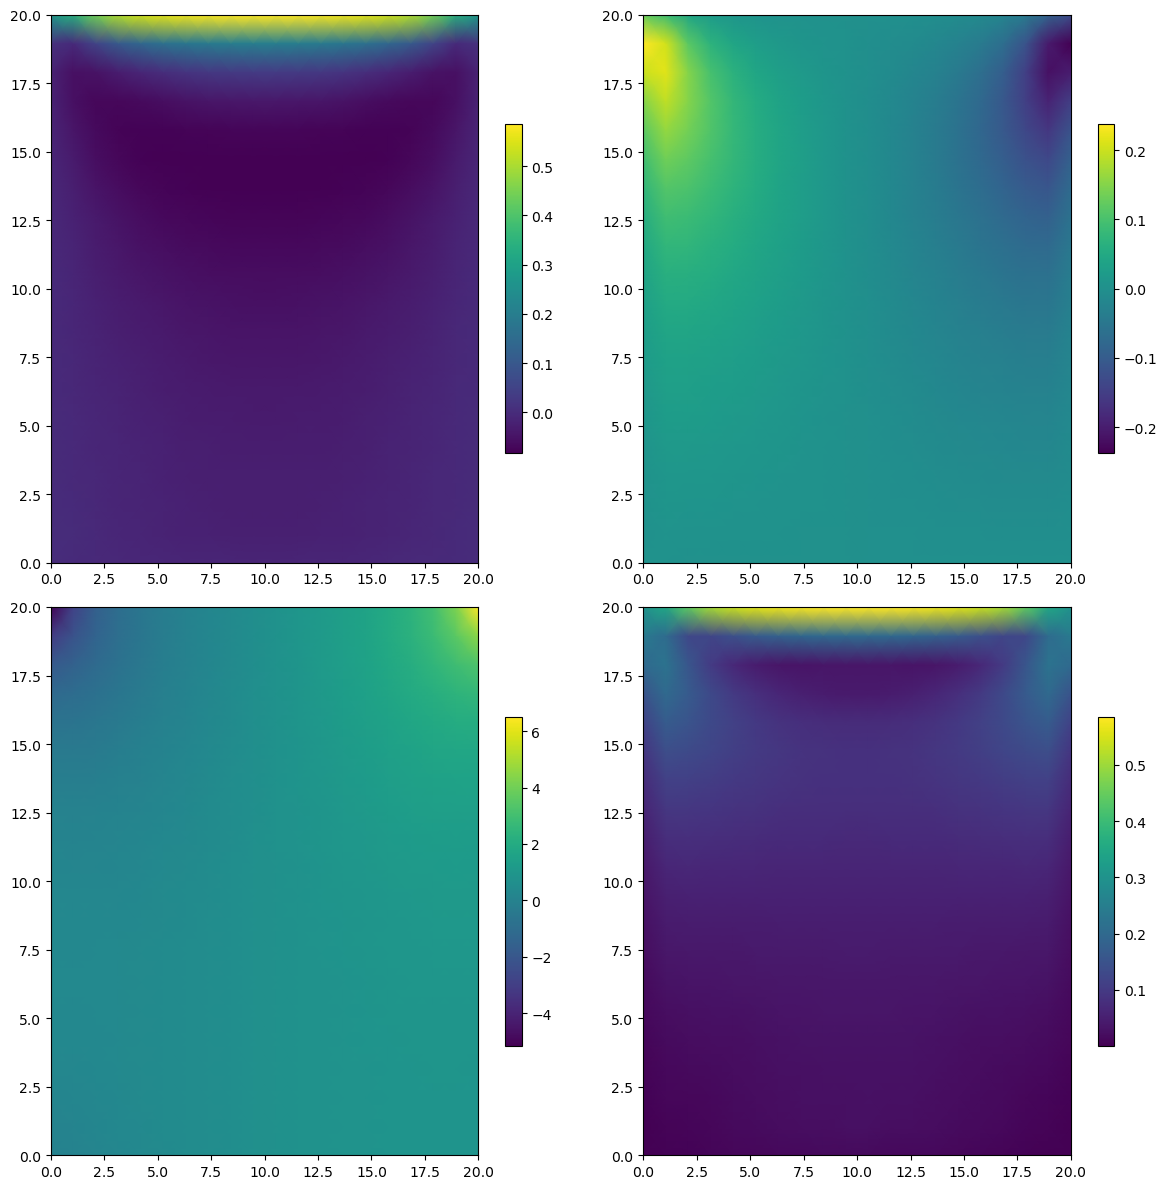

In [20]:
#QC training/testing selection with GIF using additional scatter ontop of quiver...will that work?
#Takes about 1.5 minutes to compute

#Decimate the timesteps for GIF output to avoid huge files and long creation time
animation_num_frames = 50
animation_write_interval = int(math.floor(ofoam_num_outputs / animation_num_frames))
print(f"Animation write interval: {animation_write_interval}")
print(f"OpenFOAM outputs: {ofoam_num_outputs}")
print(f"OpenFOAM start-end(dt): {start_time}-{end_time}({dt})")
print(f"# of animation frames: {animation_num_frames}")
print(f"OpenFOAM timesteps in animation: {range(0,int(ofoam_num_outputs),animation_write_interval)}")

fig, ax = plt.subplots(2,2, figsize=(12, 12))
fig.tight_layout()

#Compute magnitude of velocity
u_mag_full = np.sqrt(u_full.astype(np.double)**2 + v_full.astype(np.double)**2).astype(float)

#Use first timestep after initial condition to set the colour bar
fig.colorbar(ax[0][0].pcolormesh(grid2d_x,grid2d_y, u_full[1,:,:], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[0][1].pcolormesh(grid2d_x,grid2d_y, v_full[1,:,:], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[1][0].pcolormesh(grid2d_x,grid2d_y, p_full[1,:,:], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[1][1].pcolormesh(grid2d_x,grid2d_y, u_mag_full[1,:,:], shading='gouraud'), shrink=0.6, orientation='vertical')

def animate_subplot(i):
    #Indexing values for plotting and GIF creation
    timestep_index = animation_write_interval * i
    timestep_time = timestep_index * dt

    fig.suptitle(f"Timestep value: {timestep_time}", fontsize=16)

    ax[0][0].pcolormesh(grid2d_x,grid2d_y, u_full[timestep_index,:,:], shading='gouraud')

    if timestep_index != 0:
        ax[0][0].quiver(grid2d_x,grid2d_y, u_full[timestep_index,:,:],v_full[timestep_index,:,:])

    ax[0][0].scatter(
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,2],
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,1], 
        c="Red",
        alpha=1,
        marker="x")
    ax[0][0].scatter(
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,2],
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[0][0].scatter(
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,2],
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[0][0].scatter(
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,2],
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,1], 
        c="Yellow",
        alpha=1,
        marker="x")

    ax[0][0].set_title("Velocity (u)")
    ax[0][0].set_ylabel("Spatial y index")
    ax[0][0].set_xlabel("Spatial x index")
    ax[0][0].set_box_aspect(1)

    ax[0][1].pcolormesh(grid2d_x,grid2d_y, v_full[timestep_index,:,:], shading='gouraud')
    if timestep_index != 0:
        ax[0][1].quiver(grid2d_x,grid2d_y, u_full[timestep_index,:,:],v_full[timestep_index,:,:])

    ax[0][1].scatter(
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,2],
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,1], 
        c="Red",
        alpha=1,
        marker="x")
    ax[0][1].scatter(
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,2],
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[0][1].scatter(
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,2],
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[0][1].scatter(
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,2],
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,1], 
        c="Yellow",
        alpha=1,
        marker="x")

    ax[0][1].set_title("Velocity (v)")
    ax[0][1].set_ylabel("Spatial y index")
    ax[0][1].set_xlabel("Spatial x index")
    ax[0][1].set_box_aspect(1)

    ax[1][0].pcolormesh(grid2d_x,grid2d_y, p_full[timestep_index,:,:], shading='gouraud')
    if timestep_index != 0:
        ax[1][0].quiver(grid2d_x,grid2d_y, u_full[timestep_index,:,:],v_full[timestep_index,:,:])

    ax[1][0].scatter(
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,2],
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,1], 
        c="Red",
        alpha=1,
        marker="x")
    ax[1][0].scatter(
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,2],
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[1][0].scatter(
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,2],
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[1][0].scatter(
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,2],
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,1], 
        c="Yellow",
        alpha=1,
        marker="x")

    ax[1][0].set_title("Pressure")
    ax[1][0].set_ylabel("Spatial y index")
    ax[1][0].set_xlabel("Spatial x index")
    ax[1][0].set_box_aspect(1)

    ax[1][1].pcolormesh(grid2d_x,grid2d_y, u_mag_full[timestep_index,:,:], shading='gouraud')
    if timestep_index != 0:
        ax[1][1].quiver(grid2d_x,grid2d_y, u_full[timestep_index,:,:],v_full[timestep_index,:,:])

    ax[1][1].scatter(
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,2],
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,1], 
        c="Red",
        alpha=1,
        marker="x")
    ax[1][1].scatter(
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,2],
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[1][1].scatter(
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,2],
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[1][1].scatter(
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,2],
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,1], 
        c="Yellow",
        alpha=1,
        marker="x")

    ax[1][1].set_title("Velocity magntiude")
    ax[1][1].set_ylabel("Spatial y index")
    ax[1][1].set_xlabel("Spatial x index")
    ax[1][1].set_box_aspect(1)

if save_animation == True:
    ani = animation.FuncAnimation(fig, animate_subplot, int(animation_num_frames), interval=1)
    writervideo = animation.FFMpegWriter(fps=20)
    ani.save(f'../../animations/full_openfoam_ofeqns_training_outputframes{animation_num_frames}.mp4',writer=writervideo)

In [21]:
#Scale features
scaled_features_basewall = scaler_features.transform(features_basewall)
scaled_features_interior = scaler_features.transform(features_interior)
scaled_features_leftwall = scaler_features.transform(features_leftwall)
scaled_features_rightwall = scaler_features.transform(features_rightwall)
#Now split each dataset into training and testing

#Train test splitting
test_size = 0.7

#Interior
(
    x_interior_train,
    x_interior_test,
    y_interior_train,
    y_interior_test,
    t_interior_train,
    t_interior_test,
    u_interior_train,
    u_interior_test,
    v_interior_train,
    v_interior_test,
    p_interior_train,
    p_interior_test,
) = train_test_split(
    scaled_features_interior[:,2], 
    scaled_features_interior[:,1], 
    scaled_features_interior[:,0],
    u_interior_labels,
    v_interior_labels,
    p_interior_labels,
    test_size=test_size)

#Basewall
(
    x_basewall_train,
    x_basewall_test,
    y_basewall_train,
    y_basewall_test,
    t_basewall_train,
    t_basewall_test,
    u_basewall_train,
    u_basewall_test,
    v_basewall_train,
    v_basewall_test,
    p_basewall_train,
    p_basewall_test,
) = train_test_split(
    scaled_features_basewall[:,2], 
    scaled_features_basewall[:,1], 
    scaled_features_basewall[:,0],
    u_basewall_labels,
    v_basewall_labels,
    p_basewall_labels,
    test_size=test_size)

#Leftwall
(
    x_leftwall_train,
    x_leftwall_test,
    y_leftwall_train,
    y_leftwall_test,
    t_leftwall_train,
    t_leftwall_test,
    u_leftwall_train,
    u_leftwall_test,
    v_leftwall_train,
    v_leftwall_test,
    p_leftwall_train,
    p_leftwall_test,
) = train_test_split(
    scaled_features_leftwall[:,2], 
    scaled_features_leftwall[:,1], 
    scaled_features_leftwall[:,0],
    u_leftwall_labels,
    v_leftwall_labels,
    p_leftwall_labels,
    test_size=test_size)

#Rightwall
(
    x_rightwall_train,
    x_rightwall_test,
    y_rightwall_train,
    y_rightwall_test,
    t_rightwall_train,
    t_rightwall_test,
    u_rightwall_train,
    u_rightwall_test,
    v_rightwall_train,
    v_rightwall_test,
    p_rightwall_train,
    p_rightwall_test,
) = train_test_split(
    scaled_features_rightwall[:,2], 
    scaled_features_rightwall[:,1], 
    scaled_features_rightwall[:,0],
    u_rightwall_labels,
    v_rightwall_labels,
    p_rightwall_labels,
    test_size=test_size)

In [22]:
#Now combine data into contiguous arrays suitable for Tensorflow
u_boundary_train = np.concatenate((
    u_rightwall_train,
    u_leftwall_train,
    u_basewall_train
))

v_boundary_train = np.concatenate((
    v_rightwall_train,
    v_leftwall_train,
    v_basewall_train
))

p_boundary_train = np.concatenate((
    p_rightwall_train,
    p_leftwall_train,
    p_basewall_train
))

x_boundary_train = np.concatenate((
    x_rightwall_train,
    x_leftwall_train,
    x_basewall_train
))

y_boundary_train = np.concatenate((
    y_rightwall_train,
    y_leftwall_train,
    y_basewall_train
))

t_boundary_train = np.concatenate((
    t_rightwall_train,
    t_leftwall_train,
    t_basewall_train
))

u_boundary_test = np.concatenate((
    u_rightwall_test,
    u_leftwall_test,
    u_basewall_test
))

v_boundary_test = np.concatenate((
    v_rightwall_test,
    v_leftwall_test,
    v_basewall_test
))

p_boundary_test = np.concatenate((
    p_rightwall_test,
    p_leftwall_test,
    p_basewall_test
))

x_boundary_test = np.concatenate((
    x_rightwall_test,
    x_leftwall_test,
    x_basewall_test
))

y_boundary_test = np.concatenate((
    y_rightwall_test,
    y_leftwall_test,
    y_basewall_test
))

t_boundary_test = np.concatenate((
    t_rightwall_test,
    t_leftwall_test,
    t_basewall_test
))

In [23]:
# Define MLP model architecture class
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        """_summary_
        """
        super().__init__()
        self.linear_stack = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3)
        )

    def forward(self, x, y, t):
        """_summary_

        Args:
            x (_type_): _description_
            t (_type_): _description_

        Returns:
            _type_: _description_
        """
        inputs = torch.cat(
            [x.reshape(-1,1),
            y.reshape(-1,1),
            t.reshape(-1,1)], 
            axis=1).to(device)
        
        return self.linear_stack(inputs)

In [24]:
#Training loop
def train_loop(
    x_interior, y_interior, t_interior,\
    u_interior, v_interior, p_interior,\
    x_boundary, y_boundary, t_boundary,\
    u_boundary, v_boundary, p_boundary,\
    model, loss_fn, optimizer, writer=None):
    """_summary_

    Args:
        x_interior (_type_): _description_
        y_interior (_type_): _description_
        t_interior (_type_): _description_
        v_interior (_type_): _description_
        p_interior (_type_): _description_
        y_boundary (_type_): _description_
        t_boundary (_type_): _description_
        v_boundary (_type_): _description_
        p_boundary (_type_): _description_
        loss_fn (_type_): _description_
        optimizer (_type_): _description_
        writer (_type_, optional): _description_. Defaults to None.
    """
    #Ensure gradients are set to zero
    optimizer.zero_grad()

    #Get predictions for u,v and p
    interior_pred = model(x_interior, y_interior, t_interior)
    boundary_pred = model(x_boundary, y_boundary, t_boundary)
    
    print(f"interior_pred.shape {interior_pred.shape}")
    print(f"boundary_pred.shape {boundary_pred.shape}")

    #Concatenate u,v,p into single tensor for loss calculation
    interior_labels = torch.cat(
        [u_interior.reshape(-1,1),
         v_interior.reshape(-1,1), 
         p_interior.reshape(-1,1)], 
         axis=1).to(device)
    
    boundary_labels = torch.cat(
        [u_boundary.reshape(-1,1), 
         v_boundary.reshape(-1,1), 
         p_boundary.reshape(-1,1)], 
         axis=1).to(device)
    
    print(f"interior_labels.shape {interior_labels.shape}")
    print(f"boundary_labels.shape {boundary_labels.shape}")

    #Get loss for u,v and p on interior, PDE and boundary conditions (6 outputs)
    boundary_loss, pde_loss, data_loss = loss_fn(
        interior_pred, boundary_pred,
        interior_labels, boundary_labels,
        x_interior, y_interior, t_interior)
    
    print(f"\tBefore adaption: Boundary condition loss: {boundary_loss}")
    print(f"\tBefore adaption: PDE loss: {pde_loss}")
    print(f"\tBefore adaption: Data loss: {data_loss}")

    #Calculate dBoundaryLoss/dTheta
    boundary_loss.backward(retain_graph=True)
    bound_grads = []
    for name, param in model.named_parameters():
        if "weight" in name:
            bound_grads.append(param.grad.view(-1))
    
    bound_grads = torch.cat(bound_grads)
    optimizer.zero_grad()
    
    #Calculate dInitialLoss/dTheta
    pde_loss.backward(retain_graph=True)
    pde_grads = []
    for name, param in model.named_parameters():
        if "weight" in name:
            pde_grads.append(param.grad.view(-1))
    
    pde_grads = torch.cat(pde_grads)
    optimizer.zero_grad()

    #Calculate dDataLoss/dTheta
    data_loss.backward(retain_graph=True)
    data_grads = []
    for name, param in model.named_parameters():
        if "weight" in name:
            data_grads.append(param.grad.view(-1))    
    
    data_grads = torch.cat(data_grads)
    optimizer.zero_grad()

    #Compute adaptive weight for each component of total loss
    #relative to the mean gradient of data_loss w.r.t layer weights
    boundary_loss_weight = torch.max(torch.abs(data_grads)) / torch.mean(torch.abs(bound_grads))
    pde_loss_weight = torch.max(torch.abs(data_grads)) / torch.mean(torch.abs(pde_grads))
    data_loss_weight = torch.max(torch.abs(data_grads)) / torch.mean(torch.abs(data_grads))

    #Create total loss to update all network parameters
    total_loss = \
        (data_loss * data_loss_weight) + \
        (pde_loss_weight * pde_loss) + \
        (boundary_loss_weight * boundary_loss)
    
    print(f"\t\tAfter adaption: Boundary condition loss: {boundary_loss * boundary_loss_weight}")
    print(f"\t\tAfter adaption: PDE loss: {pde_loss * pde_loss_weight}")
    print(f"\t\tAfter adaption: Data loss: {data_loss * data_loss_weight}")

    #Write QC data to Tensorboard
    if writer:
        writer.add_scalar('training_boundary_loss',boundary_loss,epoch)
        writer.add_scalar('training_pde_loss',pde_loss,epoch)
        writer.add_scalar('training_data_loss',data_loss,epoch)
        writer.add_scalar('training_weighted_boundary_loss',boundary_loss * boundary_loss_weight,epoch)
        writer.add_scalar('training_weighted_pde_loss',pde_loss * pde_loss_weight,epoch)
        writer.add_scalar('training_weighted_data_loss',data_loss * data_loss_weight,epoch)
        writer.add_scalar('training_boundary_loss_weight',boundary_loss_weight,epoch)
        writer.add_scalar('training_pde_loss_weight',pde_loss_weight,epoch)
        writer.add_scalar('training_data_loss_weight',data_loss_weight,epoch)
        writer.add_scalar('training_data_mean_grad', torch.mean(torch.abs(data_grads)))
        writer.add_scalar('training_pde_mean_grad', torch.mean(torch.abs(pde_grads)))
        writer.add_scalar('training_bound_mean_grad', torch.mean(torch.abs(bound_grads)))
        
    #Update weights according to weighted loss function    
    total_loss.backward()
    optimizer.step()

In [25]:
#Testing loop
def test_loop(
        x_interior, y_interior, t_interior,\
        u_interior, v_interior, p_interior,\
        x_boundary, y_boundary, t_boundary,\
        u_boundary, v_boundary, p_boundary,\
        model, loss_fn, writer=None):
    
    #Get predictions for u,v and p
    interior_pred = model(x_interior, y_interior, t_interior)
    boundary_pred = model(x_boundary, y_boundary, t_boundary)
    
    #Concatenate u,v,p into single tensor for loss calculation
    interior_labels = torch.cat(
        [u_interior.reshape(-1,1), 
         v_interior.reshape(-1,1), 
         p_interior.reshape(-1,1)], 
         axis=1).to(device)
    
    boundary_labels = torch.cat(
        [u_boundary.reshape(-1,1), 
         v_boundary.reshape(-1,1), 
         p_boundary.reshape(-1,1)], 
         axis=1).to(device)
    
    #Get loss for u,v and p on interior, PDE and boundary conditions (6 outputs)
    boundary_loss, pde_loss, data_loss = loss_fn(
        interior_pred, boundary_pred,
        interior_labels, boundary_labels,
        x_interior, y_interior, t_interior)
    
    #Write QC data to Tensorboard
    if writer:
        writer.add_scalar('testing_boundary_loss',boundary_loss,epoch)
        writer.add_scalar('testing_pde_loss',pde_loss,epoch)
        writer.add_scalar('testing_data_loss',data_loss,epoch)
    
    print(f"\n\tTesting: Boundary condition loss: {boundary_loss}")
    print(f"\tTesting: PDE loss: {pde_loss}")
    print(f"\tTesting: Data loss: {data_loss}")

In [26]:
#Loss function
def combined_physics_data_loss(
        interior_pred, boundary_pred,
        interior_labels, boundary_labels,
        x_interior, y_interior, t_interior,
    ):
    """_summary_

    Args:
        interior_pred (_type_): _description_
        bound_pred (_type_): _description_
        init_pred (_type_): _description_
        interior_labels (_type_): _description_
        bound_labels (_type_): _description_
        init_labels (_type_): _description_
        x_interior (_type_): _description_
        t_interior (_type_): _description_

    Returns:
        _type_: _description_
    """
    #Get gradients required for 2D-Navier stokes
    u = interior_pred[:,0]
    v = interior_pred[:,1]
    p = interior_pred[:,2]

    dudt = torch.autograd.grad(u.sum(), t_interior, retain_graph=True, create_graph=True)[0]
    dudx = torch.autograd.grad(u.sum(), x_interior, retain_graph=True, create_graph=True)[0]
    dudy = torch.autograd.grad(u.sum(), y_interior, retain_graph=True, create_graph=True)[0]
    dvdt = torch.autograd.grad(v.sum(), t_interior, retain_graph=True, create_graph=True)[0]
    dvdx = torch.autograd.grad(v.sum(), x_interior, retain_graph=True, create_graph=True)[0]
    dvdy = torch.autograd.grad(v.sum(), y_interior, retain_graph=True, create_graph=True)[0]

    dpdx = torch.autograd.grad(p.sum(), x_interior, retain_graph=True, create_graph=True)[0]
    dpdy = torch.autograd.grad(p.sum(), y_interior, retain_graph=True, create_graph=True)[0]

    d2udx2 = torch.autograd.grad(dudx.sum(), x_interior, retain_graph=True, create_graph=True)[0]
    d2udy2 = torch.autograd.grad(dudx.sum(), y_interior, retain_graph=True, create_graph=True)[0]
    d2vdx2 = torch.autograd.grad(dvdx.sum(), x_interior, retain_graph=True, create_graph=True)[0]
    d2vdy2 = torch.autograd.grad(dvdx.sum(), y_interior, retain_graph=True, create_graph=True)[0]
            
    #Compute PDE value for all X,Y,T locations in training set
    #according to derivates and constants
    
    #OpenFOAM equations
    pde_u = dudt + (u * dudx) + (v * dudy) - (viscosity * (d2udx2 + d2udy2)) + dpdx
    pde_v = dvdt + (u * dvdx) + (v * dvdy) - (viscosity * (d2vdx2 + d2vdy2)) + dpdy

    #Define loss criterion
    criterion = torch.nn.MSELoss()
    
    #Both components of the PDE should minimize to zero so creating
    #a target array equal to zero
    pde_total = torch.cat((pde_u,pde_v))
    pde_labels = torch.zeros_like(pde_total)

    pde_loss = criterion(pde_labels, pde_total)
    boundary_loss = criterion(boundary_labels, boundary_pred)
    data_loss = criterion(interior_labels, interior_pred)
    
    return boundary_loss, pde_loss, data_loss

In [27]:
#Main function
#PINN Model setup
model = NeuralNetwork()
model.to(device)
loss_fn = combined_physics_data_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Place reshaped input tensors with correct data-type and with calculation of derivatives enabled on available device
x_interior_train_tensor=torch.from_numpy(x_interior_train).float().requires_grad_().to(device)
y_interior_train_tensor=torch.from_numpy(y_interior_train).float().requires_grad_().to(device)
t_interior_train_tensor=torch.from_numpy(t_interior_train).float().requires_grad_().to(device)

x_boundary_train_tensor=torch.from_numpy(x_boundary_train).float().requires_grad_().to(device)
y_boundary_train_tensor=torch.from_numpy(y_boundary_train).float().requires_grad_().to(device)
t_boundary_train_tensor=torch.from_numpy(t_boundary_train).float().requires_grad_().to(device)

u_interior_train_tensor=torch.from_numpy(u_interior_train).float().requires_grad_().to(device)
v_interior_train_tensor=torch.from_numpy(v_interior_train).float().requires_grad_().to(device)
p_interior_train_tensor=torch.from_numpy(p_interior_train).float().requires_grad_().to(device)

u_boundary_train_tensor=torch.from_numpy(u_boundary_train).float().requires_grad_().to(device)
v_boundary_train_tensor=torch.from_numpy(v_boundary_train).float().requires_grad_().to(device)
p_boundary_train_tensor=torch.from_numpy(p_boundary_train).float().requires_grad_().to(device)

x_interior_test_tensor=torch.from_numpy(x_interior_test).float().requires_grad_().to(device)
y_interior_test_tensor=torch.from_numpy(y_interior_test).float().requires_grad_().to(device)
t_interior_test_tensor=torch.from_numpy(t_interior_test).float().requires_grad_().to(device)

x_boundary_test_tensor=torch.from_numpy(x_boundary_test).float().requires_grad_().to(device)
y_boundary_test_tensor=torch.from_numpy(y_boundary_test).float().requires_grad_().to(device)
t_boundary_test_tensor=torch.from_numpy(t_boundary_test).float().requires_grad_().to(device)

u_interior_test_tensor=torch.from_numpy(u_interior_test).float().requires_grad_().to(device)
v_interior_test_tensor=torch.from_numpy(v_interior_test).float().requires_grad_().to(device)
p_interior_test_tensor=torch.from_numpy(p_interior_test).float().requires_grad_().to(device)

u_boundary_test_tensor=torch.from_numpy(u_boundary_test).float().requires_grad_().to(device)
v_boundary_test_tensor=torch.from_numpy(v_boundary_test).float().requires_grad_().to(device)
p_boundary_test_tensor=torch.from_numpy(p_boundary_test).float().requires_grad_().to(device)

#Setup Tensorboard for QCs
tensorboard_dir_name = "weighting"
writer = SummaryWriter("runs/" + tensorboard_dir_name)

epochs = 1

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}\n-------------------------------")

    train_loop(
        x_interior_train_tensor, y_interior_train_tensor, t_interior_train_tensor,\
        u_interior_train_tensor, v_interior_train_tensor, p_interior_train_tensor,\
        x_boundary_train_tensor, y_boundary_train_tensor, t_boundary_train_tensor,\
        u_boundary_train_tensor, v_boundary_train_tensor, p_boundary_train_tensor,\
        model, loss_fn, optimizer, writer)
    
    test_loop(
        x_interior_test_tensor, y_interior_test_tensor, t_interior_test_tensor,\
        u_interior_test_tensor, v_interior_test_tensor, p_interior_test_tensor,\
        x_boundary_test_tensor, y_boundary_test_tensor, t_boundary_test_tensor,\
        u_boundary_test_tensor, v_boundary_test_tensor, p_boundary_test_tensor,\
        model, loss_fn, writer)

print("\nTraining complete!\n")


Epoch 1
-------------------------------
interior_pred.shape torch.Size([97297, 3])
boundary_pred.shape torch.Size([16816, 3])
interior_labels.shape torch.Size([97297, 3])
boundary_labels.shape torch.Size([16816, 3])
	Before adaption: Boundary condition loss: 0.15978163480758667
	Before adaption: PDE loss: 0.0002237622975371778
	Before adaption: Data loss: 0.05614708364009857
		After adaption: Boundary condition loss: 9.998769760131836
		After adaption: PDE loss: 0.3911755084991455
		After adaption: Data loss: 4.755478382110596

	Testing: Boundary condition loss: 0.15088635683059692
	Testing: PDE loss: 0.00017397524788975716
	Testing: Data loss: 0.053626950830221176

Training complete!



In [28]:
features.shape

(400400, 3)

In [29]:
scaled_features = scaler_features.transform(features)

t = scaled_features[:,0]
y = scaled_features[:,1]
x = scaled_features[:,2]

In [32]:
#Time prediction
# pred_call = "model(torch.Tensor(x),torch.Tensor(y),torch.Tensor(t))"

# import timeit
# with torch.inference_mode():
#     inference_time = timeit.timeit(stmt=pred_call, number=10000)

# print(f"Inference time: {inference_time}")

In [33]:
with torch.inference_mode():
    prediction = model(torch.Tensor(x),
                       torch.Tensor(y),
                       torch.Tensor(t))

#Convert output tensor to NumPy for plotting
prediction = prediction.cpu().detach().numpy()
print(prediction.shape)

#Get fluid dynamics components out of prediction
#and shape into same dimensions as the loaded simulation
#from openfoam numpy array
u_pred = prediction[:,0].reshape(shape)
v_pred = prediction[:,1].reshape(shape)
p_pred = prediction[:,2].reshape(shape)

(400400, 3)


Animation write interval: 20
OpenFOAM outputs: 1001.0
OpenFOAM start-end(dt): 0-5(0.005)
# of animation frames: 50
OpenFOAM timesteps in animation: range(0, 1001, 20)


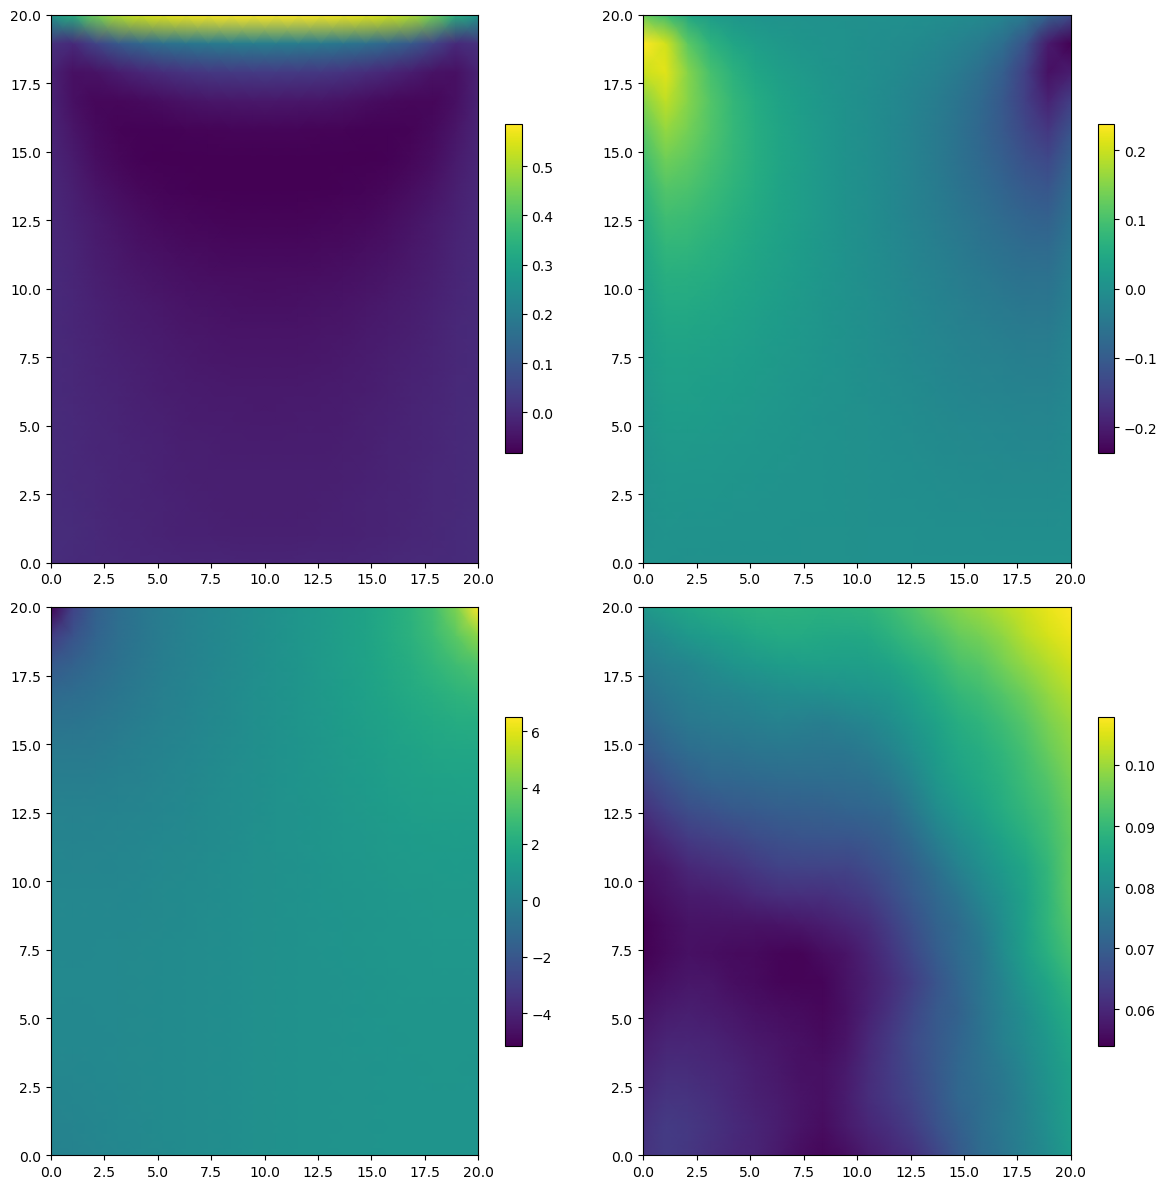

In [34]:
#QC model prediction
#Takes about 1.5 minutes to compute

#Decimate the timesteps for GIF output to avoid huge files and long creation time
animation_num_frames = 50
animation_write_interval = int(math.floor(ofoam_num_outputs / animation_num_frames))
print(f"Animation write interval: {animation_write_interval}")
print(f"OpenFOAM outputs: {ofoam_num_outputs}")
print(f"OpenFOAM start-end(dt): {start_time}-{end_time}({dt})")
print(f"# of animation frames: {animation_num_frames}")
print(f"OpenFOAM timesteps in animation: {range(0,int(ofoam_num_outputs),animation_write_interval)}")

fig, ax = plt.subplots(2,2, figsize=(12, 12))
fig.tight_layout()

#Compute magnitude of velocity from prediction
u_mag_pred = np.sqrt(u_pred.astype(np.double)**2 + v_pred.astype(np.double)**2).astype(float)

#Use first timestep from real simulation after initial condition to set the colour bar
fig.colorbar(ax[0][0].pcolormesh(grid2d_x,grid2d_y, u_full[1,:,:], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[0][1].pcolormesh(grid2d_x,grid2d_y, v_full[1,:,:], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[1][0].pcolormesh(grid2d_x,grid2d_y, p_full[1,:,:], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[1][1].pcolormesh(grid2d_x,grid2d_y, u_mag_pred[1,:,:], shading='gouraud'), shrink=0.6, orientation='vertical')

def animate_subplot(i):
    #Indexing values for plotting and GIF creation
    timestep_index = animation_write_interval * i
    timestep_time = timestep_index * dt

    fig.suptitle(f"Timestep value: {timestep_time}", fontsize=16)

    ax[0][0].pcolormesh(grid2d_x,grid2d_y, u_pred[timestep_index,:,:], shading='gouraud')

    if timestep_index != 0:
        ax[0][0].quiver(grid2d_x,grid2d_y, u_pred[timestep_index,:,:],v_pred[timestep_index,:,:])

    ax[0][0].scatter(
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,2],
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,1], 
        c="Red",
        alpha=1,
        marker="x")
    ax[0][0].scatter(
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,2],
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[0][0].scatter(
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,2],
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[0][0].scatter(
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,2],
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,1], 
        c="Yellow",
        alpha=1,
        marker="x")

    ax[0][0].set_title("Velocity (u)")
    ax[0][0].set_ylabel("Spatial y index")
    ax[0][0].set_xlabel("Spatial x index")
    ax[0][0].set_box_aspect(1)

    ax[0][1].pcolormesh(grid2d_x,grid2d_y, v_pred[timestep_index,:,:], shading='gouraud')
    if timestep_index != 0:
        ax[0][1].quiver(grid2d_x,grid2d_y, u_pred[timestep_index,:,:],v_pred[timestep_index,:,:])

    ax[0][1].scatter(
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,2],
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,1], 
        c="Red",
        alpha=1,
        marker="x")
    ax[0][1].scatter(
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,2],
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[0][1].scatter(
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,2],
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[0][1].scatter(
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,2],
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,1], 
        c="Yellow",
        alpha=1,
        marker="x")

    ax[0][1].set_title("Velocity (v)")
    ax[0][1].set_ylabel("Spatial y index")
    ax[0][1].set_xlabel("Spatial x index")
    ax[0][1].set_box_aspect(1)

    ax[1][0].pcolormesh(grid2d_x,grid2d_y, p_pred[timestep_index,:,:], shading='gouraud')
    if timestep_index != 0:
        ax[1][0].quiver(grid2d_x,grid2d_y, u_pred[timestep_index,:,:],v_pred[timestep_index,:,:])

    ax[1][0].scatter(
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,2],
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,1], 
        c="Red",
        alpha=1,
        marker="x")
    ax[1][0].scatter(
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,2],
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[1][0].scatter(
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,2],
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[1][0].scatter(
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,2],
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,1], 
        c="Yellow",
        alpha=1,
        marker="x")

    ax[1][0].set_title("Pressure")
    ax[1][0].set_ylabel("Spatial y index")
    ax[1][0].set_xlabel("Spatial x index")
    ax[1][0].set_box_aspect(1)

    ax[1][1].pcolormesh(grid2d_x,grid2d_y, u_mag_pred[timestep_index,:,:], shading='gouraud')
    if timestep_index != 0:
        ax[1][1].quiver(grid2d_x,grid2d_y, u_pred[timestep_index,:,:],v_pred[timestep_index,:,:])

    ax[1][1].scatter(
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,2],
        interior_training_locs[interior_training_locs[:,0] == timestep_time][:,1], 
        c="Red",
        alpha=1,
        marker="x")
    ax[1][1].scatter(
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,2],
        rightwall_training_locs[rightwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[1][1].scatter(
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,2],
        leftwall_training_locs[leftwall_training_locs[:,0] == timestep_time][:,1], 
        c="Purple",
        alpha=1,
        marker="x")
    ax[1][1].scatter(
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,2],
        basewall_training_locs[basewall_training_locs[:,0] == timestep_time][:,1], 
        c="Yellow",
        alpha=1,
        marker="x")

    ax[1][1].set_title("Velocity magntiude")
    ax[1][1].set_ylabel("Spatial y index")
    ax[1][1].set_xlabel("Spatial x index")
    ax[1][1].set_box_aspect(1)

if save_animation == True:
    ani = animation.FuncAnimation(fig, animate_subplot, int(animation_num_frames), interval=1)
    writervideo = animation.FFMpegWriter(fps=20)
    ani.save(f'../../animations/full_openfoam_ofeqns_prediction_outputframes{animation_num_frames}.mp4',writer=writervideo)

In [35]:
#Save the model for future use
output_model_path = f"../../models/2d-ns-pinn-{epochs}epochs-lr0.001-adam-cavity-nu0.01-u1-20x20.pt"
torch.save(model.to("cpu"), output_model_path)